# Calendar time portfolio

lazy prices 논문의 main tableII에 대한 작업이다. 

10년치 데이터의 kospi200 기업들의 사업보고서를 가지고 월별로 월말에 유사도 순으로 Q1,Q2,.. Q5 portfolio reconstruct를 하면서 그룹별 portfolio 월별 수익률을 살펴 보려고 한다. 통상 사업보고서의 filling은 3월과 4월 에 대부분 이뤄지고 6월과 8월에 공시된 것도 있었지만 그 수는 적었다. 따라서 월별로 reblancing을 계속 하지만 사실상 새로운 공시가 없으므로 포트폴리오 구성은 실제로 크게 변하지 않을 것으로 예측된다. 월별 수익률을 평균내서 포트폴리오별 수익률을 보기 때문에 사업보고서 공시월이 아닌 달에 그 효과가 경감되는 것을 고려하여 개별 월별로만 따로 수익률을 살펴볼 것이다.

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from chart_studio.plotly import plot, iplot
import cufflinks as cf
cf.go_offline(connected=True)

In [3]:
themes = cf.getThemes() #테마목록

cf.set_config_file(theme = 'pearl') #theme설정

layout = { 'font': { 'family': 'consolas', 'size': 15, 'color': 'black'  #layout설정
                   } 
         }
layout['title'] = "Title" 
#iplot 안에 layout = layout으로 

In [4]:
price_df = pd.read_csv('../data/kospi/preprocessed/df_return.csv',index_col=0)*100 #수익률들 다 % 단위로 변환
df = pd.read_csv('../data/similarity/jaccard_df.csv',index_col=0)
rm_df = pd.read_csv('../data/kospi/raw/rm_kospi200.csv',index_col=0)*100

In [13]:
abs_return = price_df.values - rm_df['return'].values[:,np.newaxis]
de_rm_df = pd.DataFrame(data=abs_return, index=price_df.index, columns=price_df.columns) #CAR 구하려고 kospi200 수익률을 뺀건데 이건 뒤에 Event time returns 구할떄 쓴다

In [14]:
de_rm_df.head() #kospi200 market return을 감해준 수익률.. CAR을 만들기 위해

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20100104,-0.280843,-1.852864,-4.610071,-3.350941,1.794038,-2.488137,3.010648,3.161752,3.373672,-0.730000,...,-0.285556,1.508806,-0.877929,0.637781,0.126311,0.379350,-1.396489,-1.155532,-0.000073,-1.232513
20100105,-0.268095,0.859003,0.107355,0.075254,-0.647026,-4.102549,-5.238005,-3.080531,-2.821192,-3.048351,...,-4.133938,1.312739,0.735285,1.940016,-2.574671,-3.627654,-0.353282,4.136995,6.571034,-0.887610
20100106,-1.605963,0.307983,2.855254,4.680736,1.190617,-1.445163,0.196595,-3.533826,4.317969,-3.184853,...,-3.136032,-1.688269,0.211231,-0.821217,-6.832755,-1.636878,0.610442,-0.409694,-0.593944,-1.161933
20100107,-0.088558,0.657213,1.850137,4.256946,1.263508,-1.032897,-3.038478,2.292478,0.884529,1.123087,...,1.969460,-0.545290,2.517425,0.168093,-0.713210,0.673158,2.294462,1.085691,0.361740,0.298946
20100108,-0.840261,-1.454001,1.156780,5.857380,0.436508,0.260469,1.500814,-1.400654,0.414586,-0.983836,...,-2.968495,6.086424,-1.043530,-0.311050,-2.156567,0.385021,-0.108023,0.213041,-0.610004,-0.436994


2010년~2011 사이에는 비교할 동일기업 사업보고서 존재하지 않으므로 유사도가 존재하지않는다. 2011년부터 발행되며 filing월은 각자 다르다.

### 월말의 유사도 기반 sorting

월말 기준으로 유사도 기반으로 portfolio reconstruct를 계속하여 sorting한 dataframe 생성

위 데이터프레임에 적용할 index별로 Q1~Q5를 sorting해주는 함수 생성

In [15]:
arr = df.values
col_ls = df.columns.values
finite_arr = ~np.isnan(arr)

In [16]:
def converter(idx) :     
    tmp_key = col_ls[finite_arr[idx]]
    tmp_val = arr[idx][finite_arr[idx]]
    tmp_dict = dict(zip(tmp_key,tmp_val))
    return tmp_dict

In [17]:
%%time
container = []
dict_ = dict(zip(col_ls, [np.nan for _ in range(len(col_ls))]))
idx_ls = []
for idx in range(1, len(arr)) : 
    tmp_dict = converter(idx)
    if len(tmp_dict) :
        idx_ls.append(idx)
    container.append(dict_.copy())
    dict_.update(tmp_dict)
container.append(dict_)

assert len(container) == len(df)

Wall time: 80.3 ms


In [18]:
df_converter = lambda x : pd.DataFrame.from_dict(x,orient='index').T
concat_df = pd.concat(map(df_converter, container),ignore_index=True)
concat_df.index = df.index 

In [19]:
ls_ = [] #np.sign이용해 모든 기업에 대하여 총 바뀐 값이 9개(10년치) 인지 확인
for i in concat_df.columns:
    if len(concat_df[np.sign(concat_df).sum(1)==113].loc[:,i].unique()) == 9:
        ls_.append(i)

len(ls_)

C:\Users\yphy0\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in sign



113

'20110629'가 처음으로 113개 기업의 작년 기준 sim values가 생기는 달. 월별 수익률을 가져올 것므로 2011.06부터 포트폴리오를 구성하겠다. 그 전에 기준 유사도값이 전부 안들어와서 nan값이 있어도 get_q로 sorting할 수는 있지만 제외하고 진행하겠음. 어차피 월별로 effect를 보면 되기 때문에

In [32]:
df_ = concat_df.loc[20110601:,:].copy()
price_df = price_df.loc[20110601:,:]
df_.head()

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110601,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.5762,...,0.873362,NaN,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.71663
20110602,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.5762,...,0.873362,NaN,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.71663
20110603,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.5762,...,0.873362,NaN,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.71663
20110604,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.5762,...,0.873362,NaN,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.71663
20110605,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.5762,...,0.873362,NaN,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.71663


In [33]:
def get_q(df_, lower_bound, upper_bound) : #quntile 설정해주면 해당 quantile에 해당하는 boolean값 반환. cross-sectional 기준
    low_q1_threshold = np.percentile(df_,lower_bound,1)
    low_q1_thres_mat = np.repeat(low_q1_threshold[:,np.newaxis],df_.shape[1],1)

    high_q1_threshold = np.percentile(df_,upper_bound,1)
    high_q1_thres_mat = np.repeat(high_q1_threshold[:,np.newaxis],df_.shape[1],1)
    
    low_bool_mat = low_q1_thres_mat > df_
    high_bool_mat1 = high_q1_thres_mat > df_
    
    low_bool_mat = low_q1_thres_mat > df_
    high_bool_mat = high_q1_thres_mat > df_
    
    return np.bitwise_and(high_bool_mat,~low_bool_mat)

In [34]:
yyyymmdd_ls = list(map(lambda x : int(str(x)[:-2]), get_q(df_,20,40).index))
idx_ls = []
for i in range(len(yyyymmdd_ls)-1) : 
    if yyyymmdd_ls[i] != yyyymmdd_ls[i+1] : 
        idx_ls.append(i)
idx_ls.append(-1) #마지막 월 추가

monthly_df = df_.loc[df_.index[idx_ls]] #월말 기준으로 앞의 concat_df에서 index만 수정해서 similarity sorting
monthly_df

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110630,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110731,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110831,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110930,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20111031,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190831,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20190930,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20191031,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20191130,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839


In [35]:
get_q(monthly_df,0,20) #하위20% Q1

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110630,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
20110731,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
20110831,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
20110930,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
20111031,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190831,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
20190930,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
20191031,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
20191130,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [22]:
def get_monthly_return(df): #월별 수익률 생성
    ex_ls = ['0'+str(x) for x in np.arange(6,10)]+['10','11','12'] #201107~201112의 월별 수익률
    month_ls = ['0'+str(x) for x in np.arange(1,10)]+['10','11','12'] #201201~201912 까지의 월별 수익률
    year_ls = [str(x) for x in np.arange(2,10)]

    ai = []
    for i in ex_ls:
        ai.append(((1+df.loc['2011'+i+'01':'2011'+i+'31'].cumsum())-1).iloc[-1,:])

    ae = []
    for i in year_ls:
        for j in month_ls:
            ae.append(((1+df.loc['201'+i+j+'01':'201'+i+j+'31'].cumsum())-1).iloc[-1,:])

    month_return_ls = ai+ae
    df_ = pd.DataFrame(month_return_ls,index=monthly_df.index)
    return df_

In [23]:
monthly_df

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110630,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110731,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110831,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20110930,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
20111031,0.482558,0.852459,0.615385,0.579749,0.630503,0.203113,0.705706,0.534641,0.596091,0.576200,...,0.873362,0.663158,0.903475,0.462889,0.577154,0.713235,0.633452,0.574394,0.755193,0.716630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190831,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20190930,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20191031,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839
20191130,0.690635,0.532609,0.727488,0.679662,0.510638,0.625402,0.678700,0.738854,0.694118,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839


In [24]:
month_return_df = get_monthly_return(price_df) 
month_return_df

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110630,10.380564,0.402374,18.079916,3.470441,19.972939,2.042747,-4.193233,8.880116,-17.136743,24.743079,...,-4.342099,6.992664,-16.620355,-3.313243,-7.685334,9.293922,6.282935,-14.258389,-1.398340,-1.472849
20110731,11.176366,8.430983,-6.263019,17.414378,-1.450413,-5.021177,7.158617,18.006126,-2.260533,13.552987,...,6.505069,15.481108,15.466949,10.574823,1.186537,12.202088,-5.463443,8.942375,27.231706,4.161142
20110831,-2.377041,-17.679701,-10.236469,-8.148054,-6.665160,-5.826276,-7.552742,-12.453355,-19.856145,-3.285173,...,-0.363095,-5.466062,-20.047054,-13.149441,-2.341771,5.853020,-8.173939,-21.718622,9.034245,-16.005166
20110930,-28.498570,-11.589057,-26.368298,1.558305,-16.086965,3.203770,2.586426,-8.532643,13.649266,-11.673791,...,-6.292796,-8.927218,-19.923446,-0.755201,1.658748,-17.922815,3.127515,-14.628223,-9.517368,-7.108627
20111031,0.995092,13.241228,15.271765,5.518332,5.973208,11.049964,1.023968,1.702360,7.869398,11.952319,...,-3.256455,9.677391,15.301895,15.334466,7.203923,12.421341,12.940560,20.384485,5.944732,8.180854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190831,-14.141390,6.248216,4.625162,-3.896803,-6.921375,-4.496395,0.104698,1.191156,1.184494,-18.156804,...,5.619673,-2.601109,-4.442501,-6.483823,-6.778203,-23.155934,6.562703,-3.113575,-21.376900,-8.701204
20190930,-0.184043,-0.097431,1.309944,5.712991,6.414312,-2.953714,4.476087,-0.601324,6.419885,7.837504,...,0.398154,4.534035,4.811443,8.365018,8.453042,4.645106,-6.738144,0.721373,2.821398,7.603917
20191031,5.798801,-1.532921,8.900251,-6.875014,-12.964354,-6.998345,-6.563799,6.003954,0.143368,0.605627,...,-5.297906,-10.352135,-1.176495,-4.093029,32.654691,-2.539379,-0.014795,-3.375752,-2.295342,-1.593231
20191130,4.002211,-3.761692,0.213539,-12.962137,-0.897137,7.747710,1.773344,10.540053,-1.126564,3.809361,...,12.281961,5.885590,-3.575285,6.040797,-0.906807,-9.036117,-6.909370,-8.698753,8.786415,9.465009


In [25]:
values = []
for i in range(0,100,20) : 
    values.append(np.nanmean(month_return_df[get_q(monthly_df,i,i+20)]))

calendar_df = pd.DataFrame(values,index=['Q1','Q2','Q3','Q4','Q5'],columns=['returns'])
calendar_df

,returns
Q1,0.301863
Q2,0.417538
Q3,0.451149
Q4,0.049495
Q5,0.274893


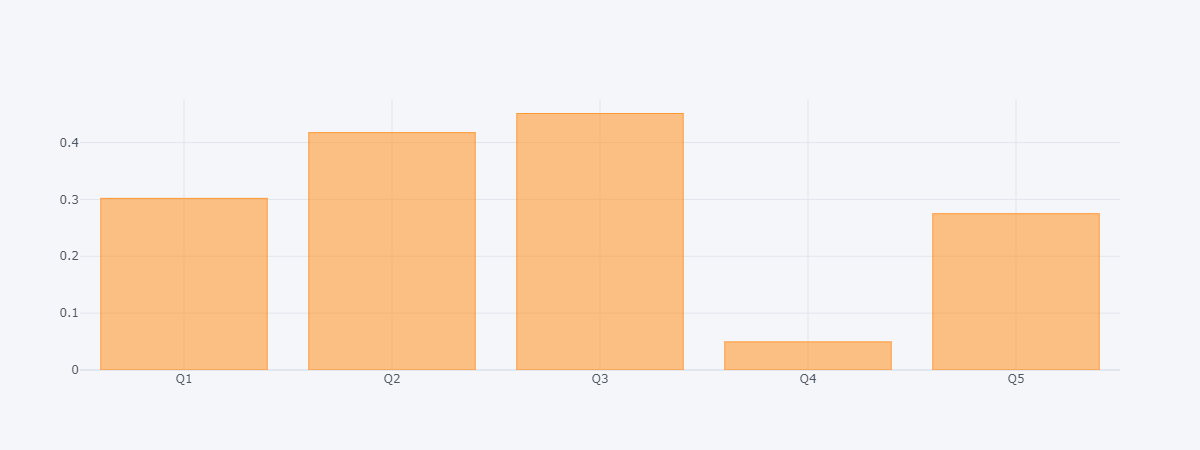

In [26]:
calendar_df.iplot(kind='bar')

## 월별 calendar return

In [ ]:
yyyymmdd_ls = list(map(lambda x : int(str(x)[:-2]), get_q(df_,20,40).index))
idx_ls = []
for i in range(len(yyyymmdd_ls)-1) : 
    if yyyymmdd_ls[i] != yyyymmdd_ls[i+1] : 
        idx_ls.append(i)
idx_ls.append(-1) #마지막 월 추가

monthly_df = df_.loc[df_.index[idx_ls]] #월말 기준으로 앞의 concat_df에서 index만 수정해서 similarity sorting
monthly_df

In [106]:
yyyymmdd_list = list(map(lambda x: int(str(x)[4:6]),month_return_df.index))
idx_list = []
for k in range(1,13):
    inline_list=[]
    for i in range(len(yyyymmdd_list)): 
        if yyyymmdd_list[i] == k:
            inline_list.append(i)
    idx_list.append(inline_list) #1~12월에 해당하는 idx_list 생성

monthly_return_ls = [month_return_df.iloc[idx_list[x],:] for x in range(0,len(idx_list))] #monthly slicing df
            

In [163]:
calendar_ls = [] #월별 calendar return dataframe 저장
for i in range(0,len(monthly_return_ls)):
    init_values = []
    for j in range(0,100,20) : 
        init_values.append(np.nanmean(monthly_return_ls[i][get_q(monthly_df,j,j+20)]))
    init_calendar_df = pd.DataFrame(init_values,index=['Q1','Q2','Q3','Q4','Q5'],columns=['returns'])
    calendar_ls.append(init_calendar_df)


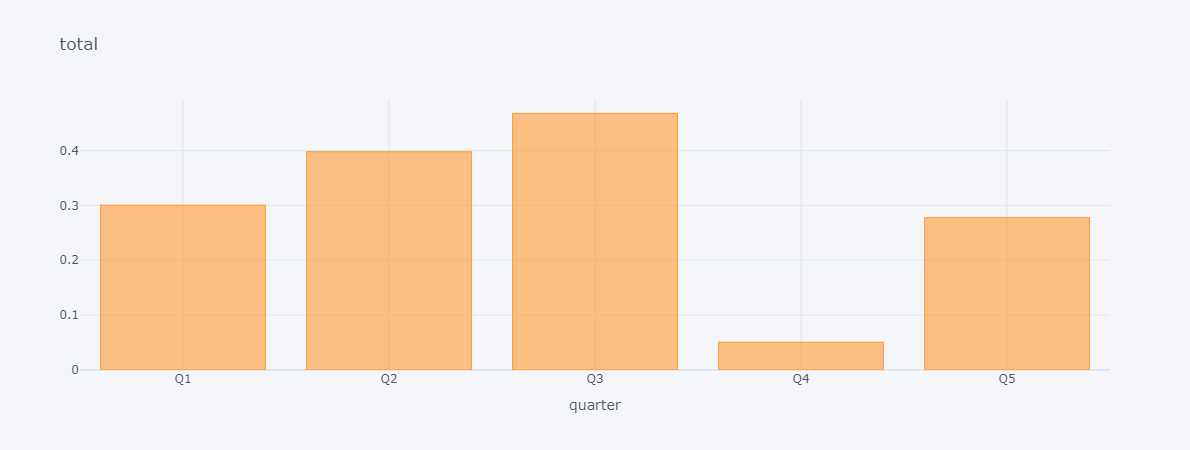

In [180]:
calendar_df.iplot(kind='bar',title='total',xTitle='quarter')

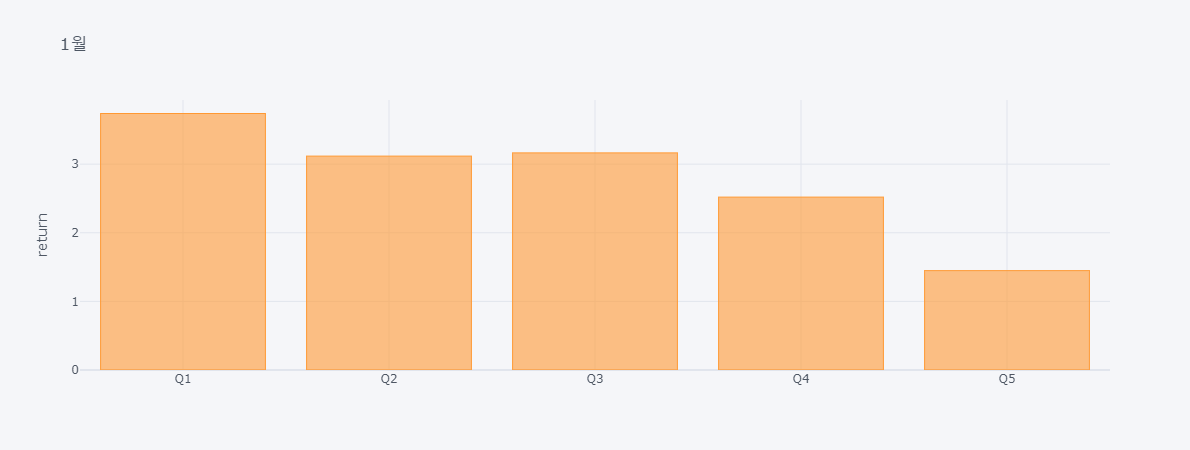

None


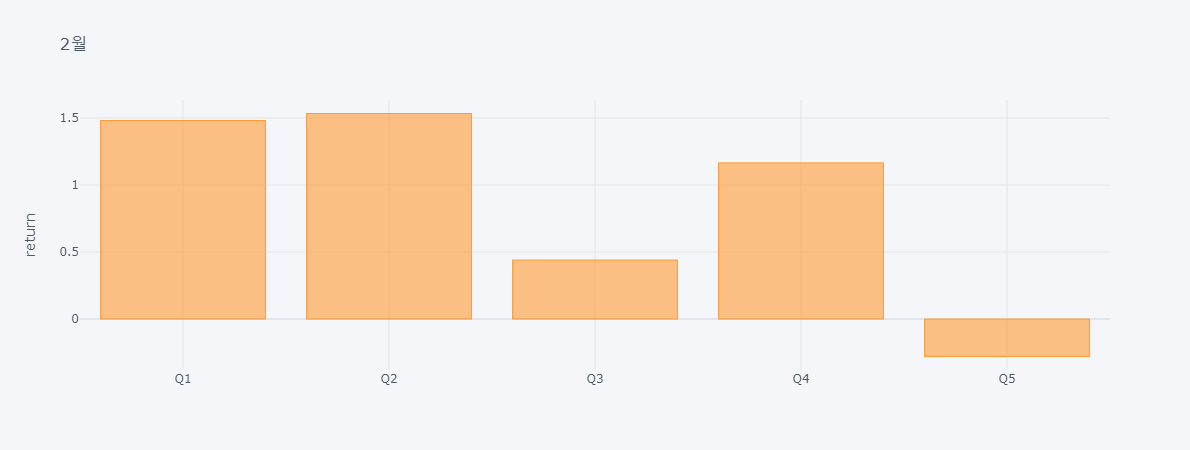

None


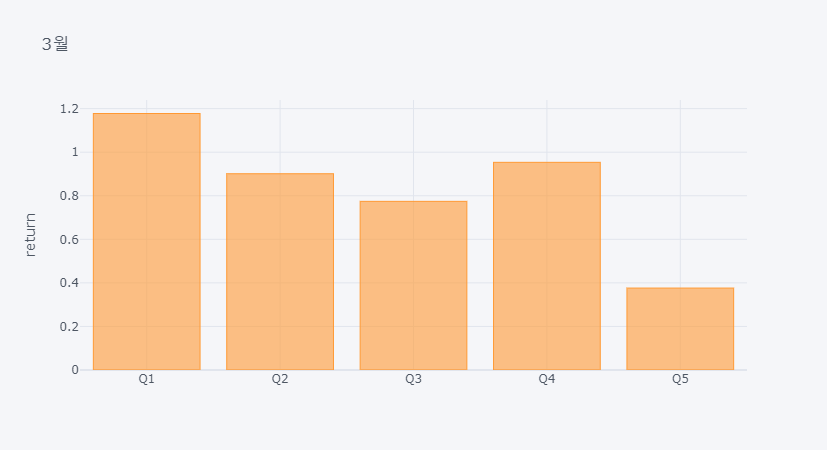

None


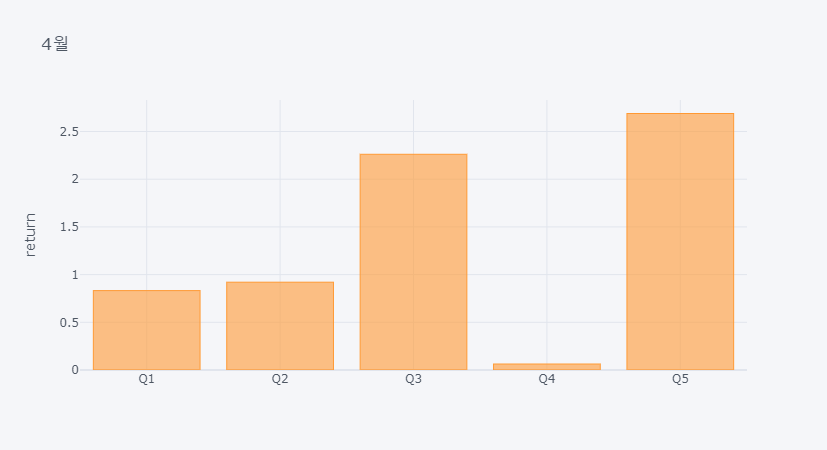

None


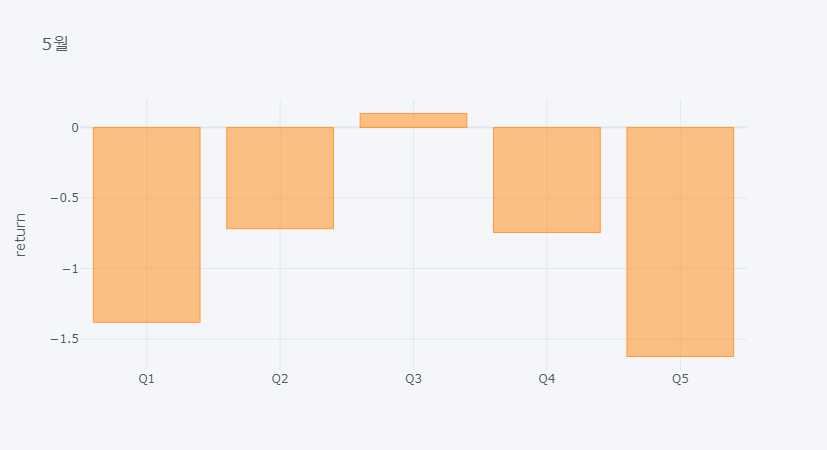

None


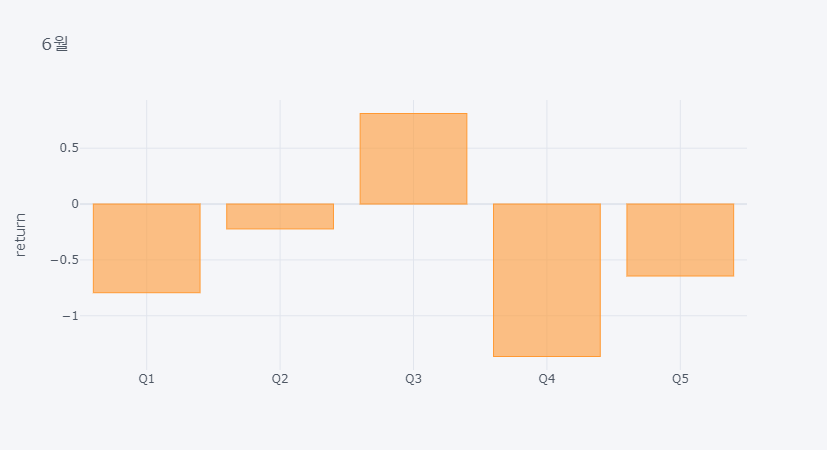

None


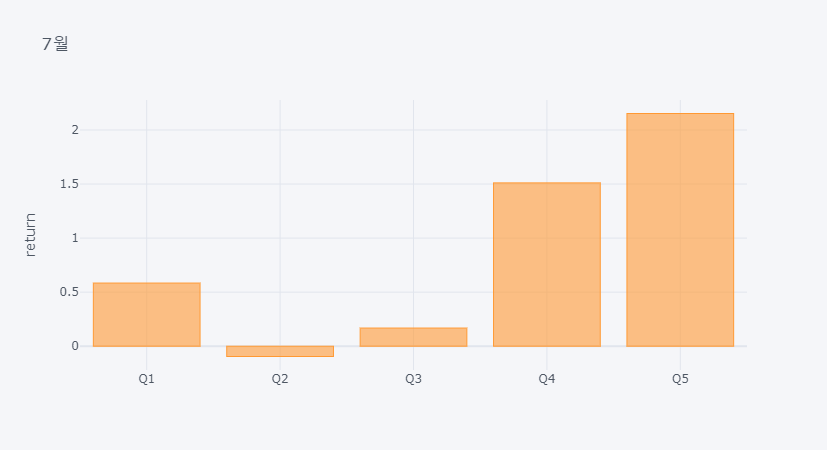

None


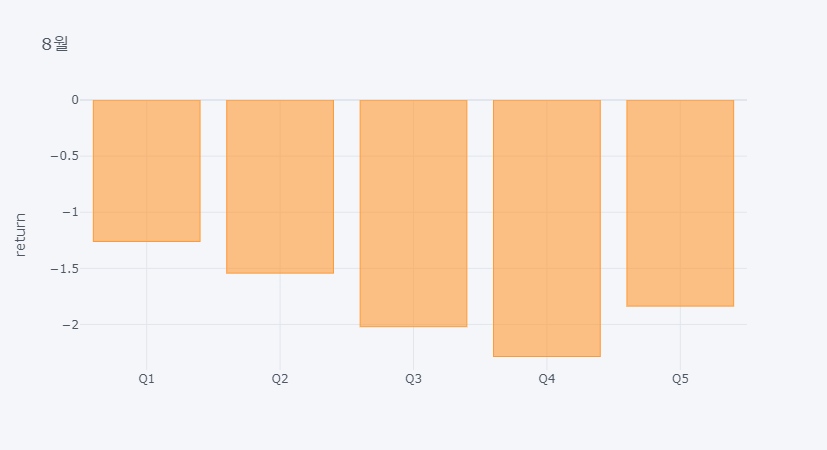

None


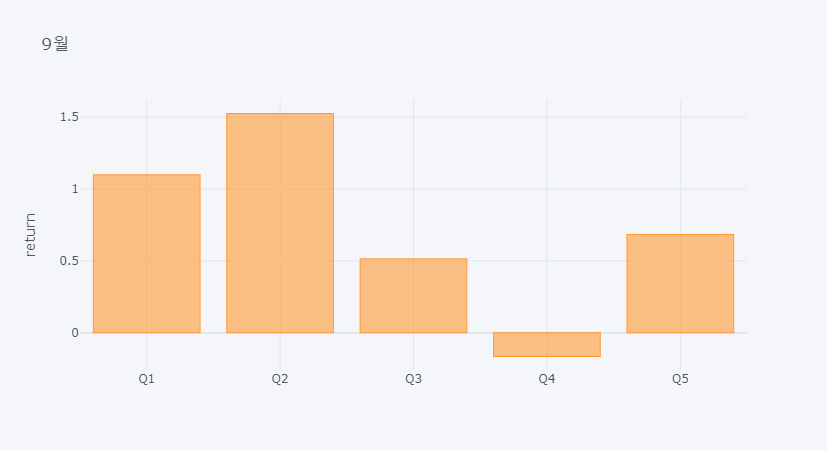

None


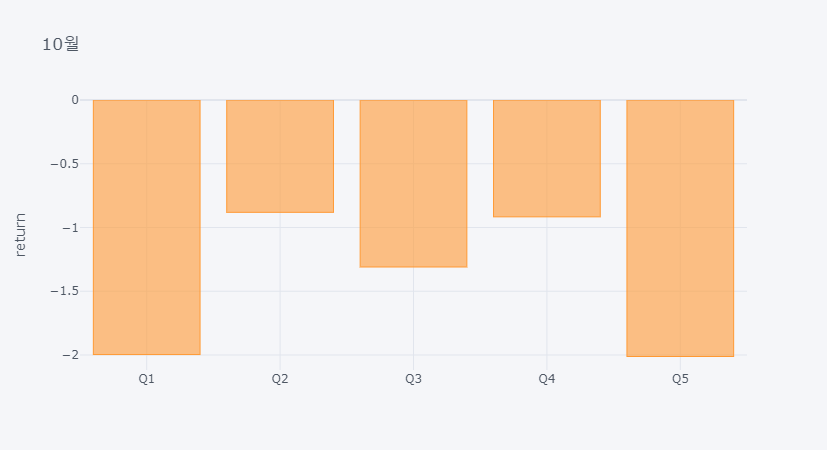

None


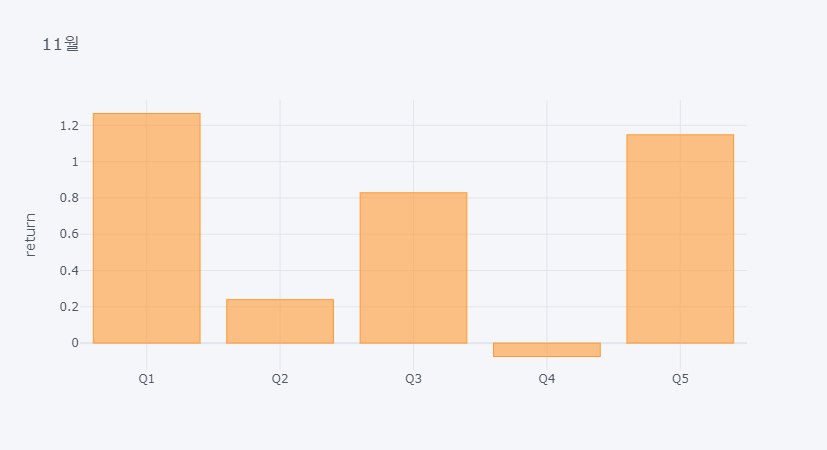

None


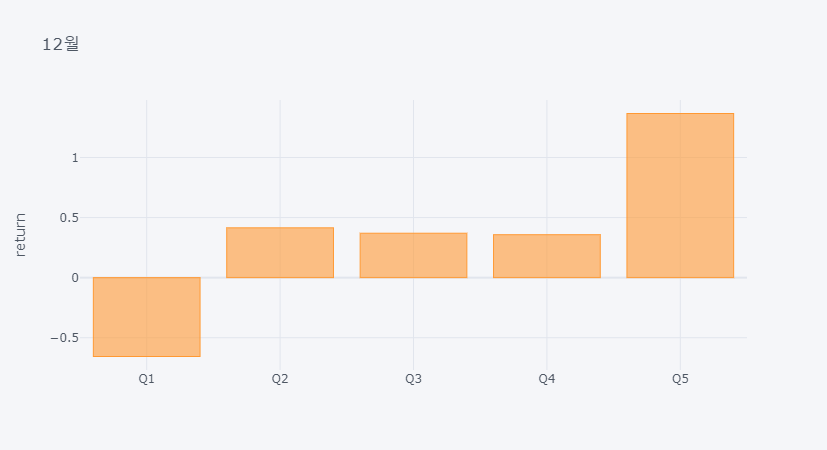

None


In [186]:
for i in range(0,len(calendar_ls)):
    print(calendar_ls[i].iplot(kind='bar',title = f'{i+1}월',yTitle='return'))